In [1]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS No_Crimes, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)
crime_type.No_Crimes = crime_type.No_Crimes.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)

mix_type = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')
mix_type

,Community Area Number,No_Crimes,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
5,1.0,221.0,CRIMINAL TRESPASS,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
6,1.0,22.6,CRIM SEXUAL ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
7,1.0,206.0,DECEPTIVE PRACTICE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
8,1.0,11.0,GAMBLING,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
9,1.0,4.0,HOMICIDE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [2]:
crime_type["Primary_Type"].unique()

array(['ASSAULT', 'BATTERY', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'OTHER OFFENSE', 'THEFT', 'ARSON', 'BURGLARY',
       'CRIM SEXUAL ASSAULT', 'GAMBLING', 'HOMICIDE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'PROSTITUTION', 'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION',
       'ROBBERY', 'SEX OFFENSE', 'STALKING', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [3]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz

from urllib.parse import quote

import scipy
from scipy import stats
from scipy import special
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/bac2qh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# create a logit-processed dataframe
mix_type_logit = mix_type.copy()
mix_type_logit['PERCENT OF HOUSING CROWDED'] = scipy.special.logit(mix_type_logit['PERCENT OF HOUSING CROWDED']/100)
mix_type_logit['PERCENT HOUSEHOLDS BELOW POVERTY'] = scipy.special.logit(mix_type_logit['PERCENT HOUSEHOLDS BELOW POVERTY']/100)
mix_type_logit['PERCENT AGED 16+ UNEMPLOYED'] = scipy.special.logit(mix_type_logit['PERCENT AGED 16+ UNEMPLOYED']/100)
mix_type_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA'] = scipy.special.logit(mix_type_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA']/100)
mix_type_logit['PERCENT AGED UNDER 18 OR OVER 64'] = scipy.special.logit(mix_type_logit['PERCENT AGED UNDER 18 OR OVER 64']/100)

In [5]:
mix_type_logit.Primary_Type.unique()

array(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE',
       'CRIMINAL TRESPASS', 'CRIM SEXUAL ASSAULT', 'DECEPTIVE PRACTICE',
       'GAMBLING', 'HOMICIDE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION',
       'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER OFFENSE', 'PROSTITUTION',
       'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [6]:
mix_type_logit.columns

Index(['Community Area Number', 'No_Crimes', 'Primary_Type',
       'COMMUNITY AREA NAME', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

In [7]:
socio_list = ['PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX']

In [8]:
crimes_list = ['HOMICIDE', 'WEAPONS VIOLATION', 'THEFT', 'KIDNAPPING', 'NARCOTICS', 'ROBBERY', 'SEX OFFENSE']

In [9]:
# # homicide = mix_type_logit.loc[(mix_type_logit['Primary_Type'] =='HOMICIDE')]  
# crimes_df = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[counter])]
# # ax = plt.figure()
# crimes_df
# # homicide
# # ax = sns.regplot(x = socio_list[counter], y = 'No_Crimes', data = crimes_df, scatter_kws = {"alpha" : 0.6})


/home/bac2qh/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


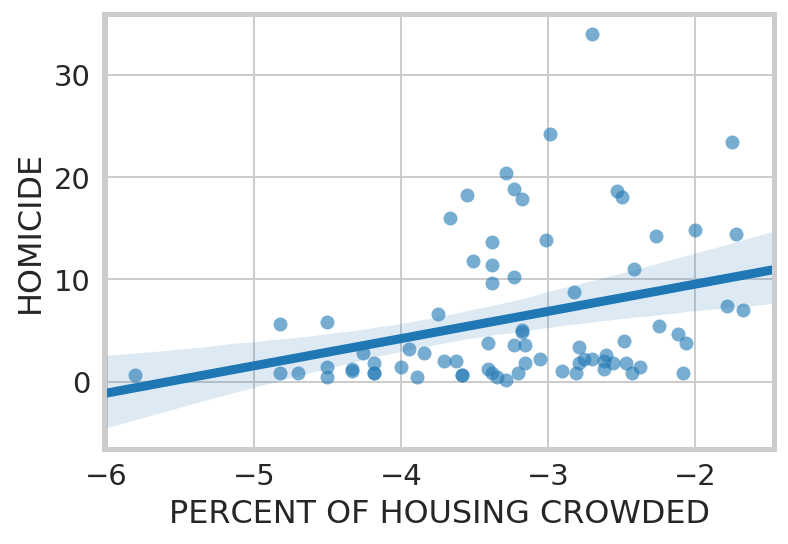

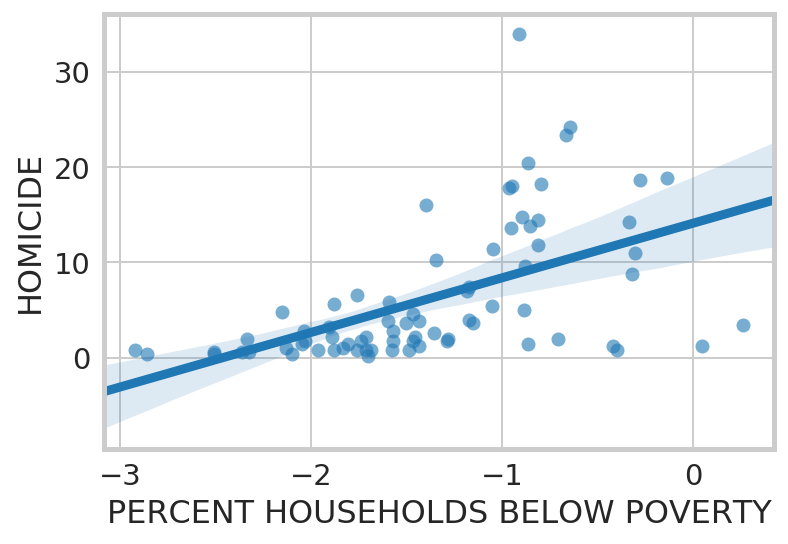

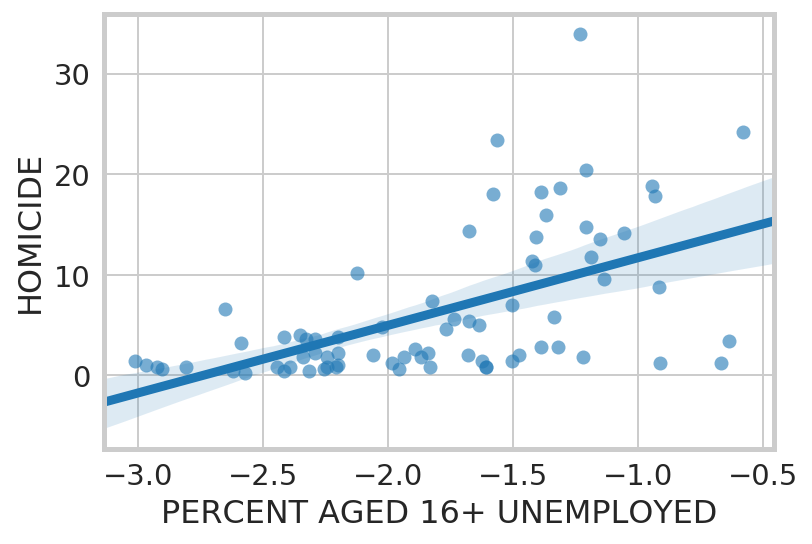

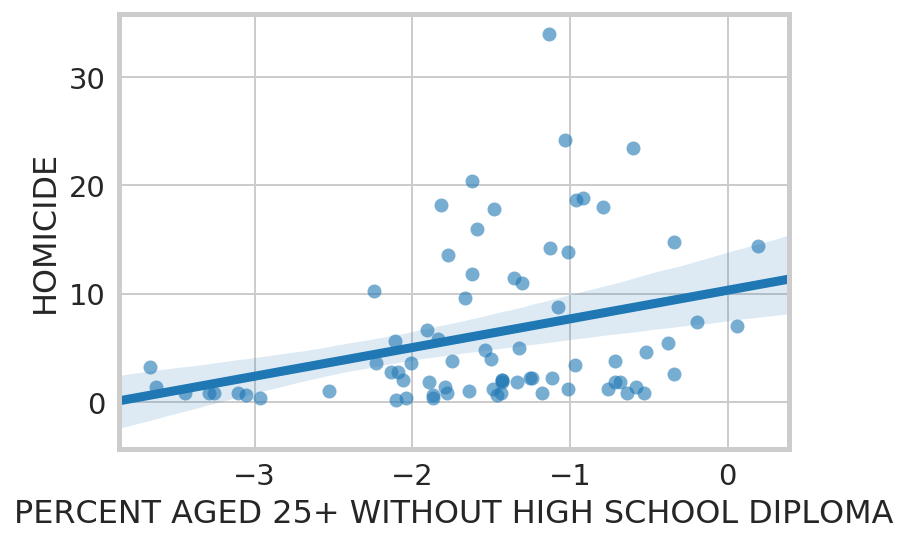

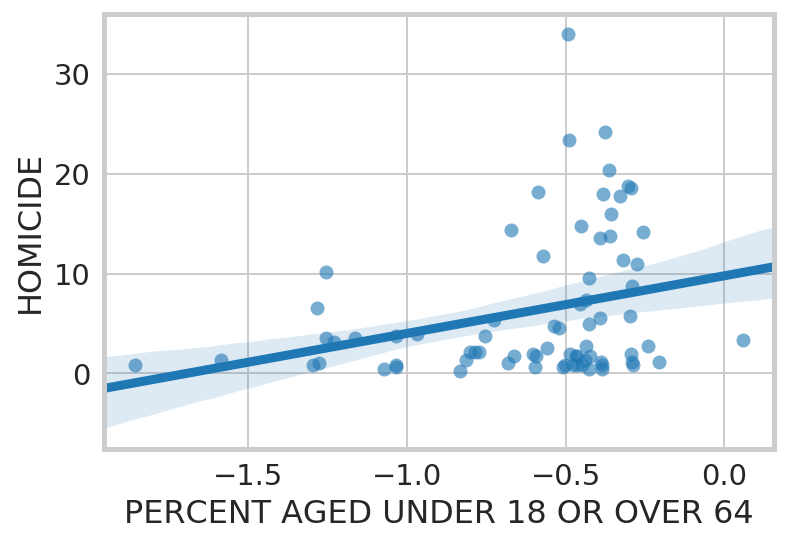

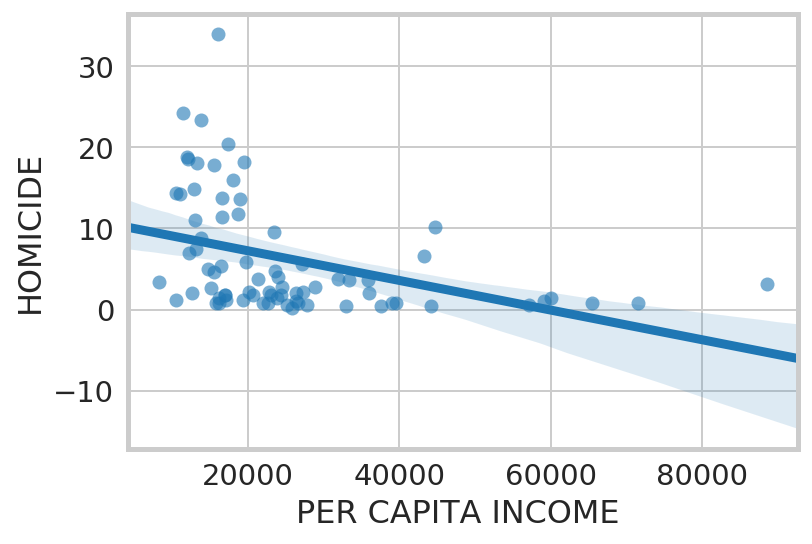

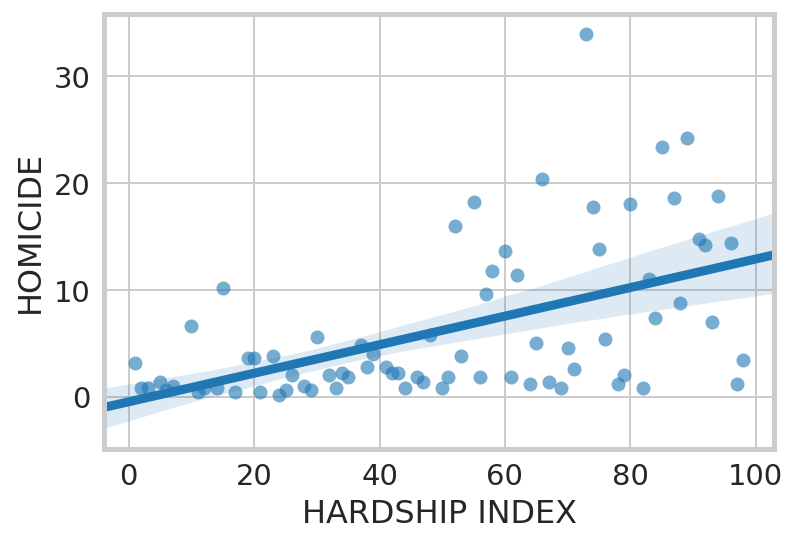

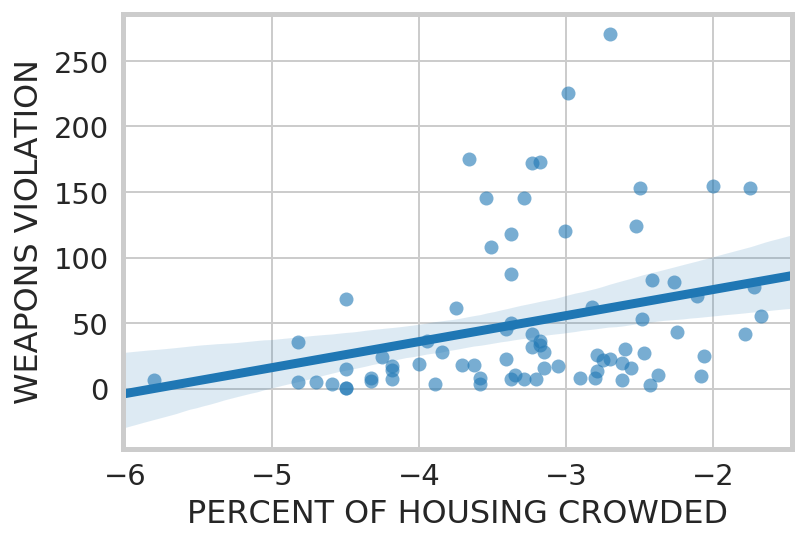

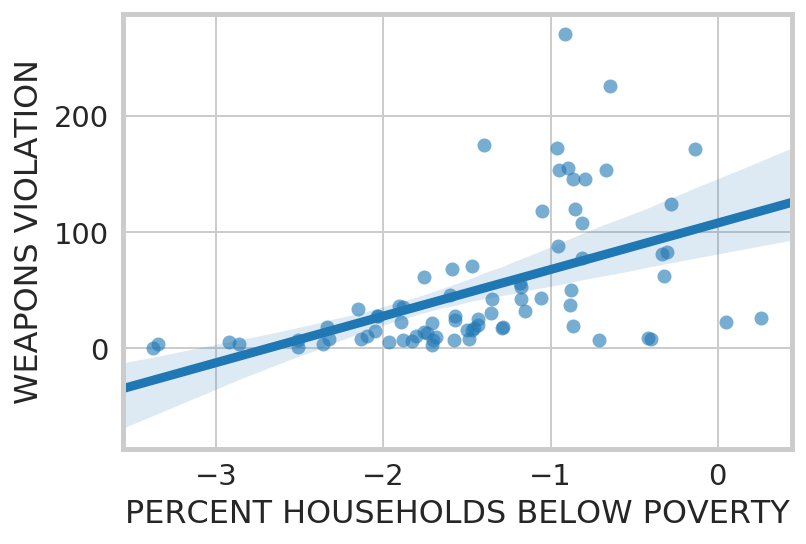

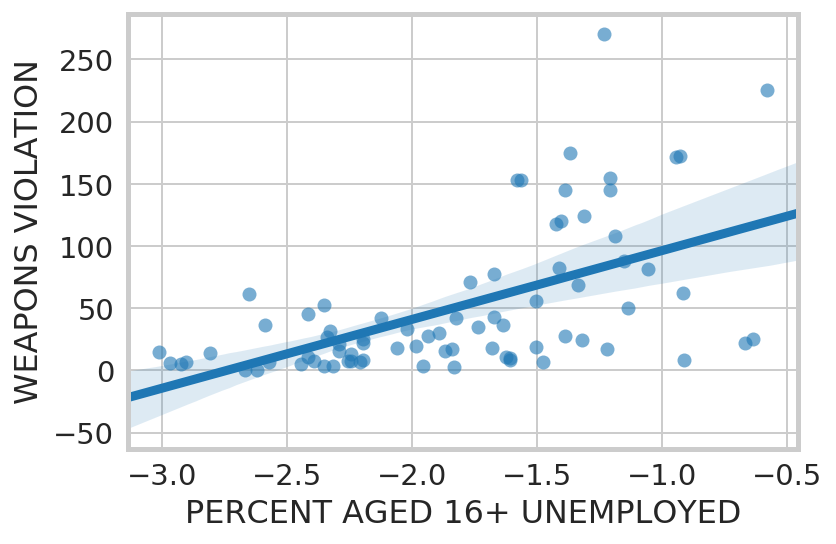

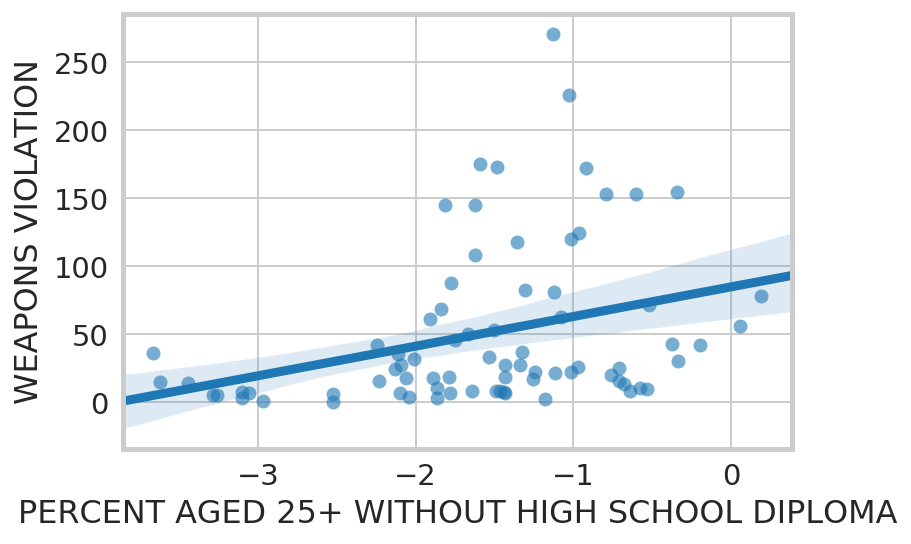

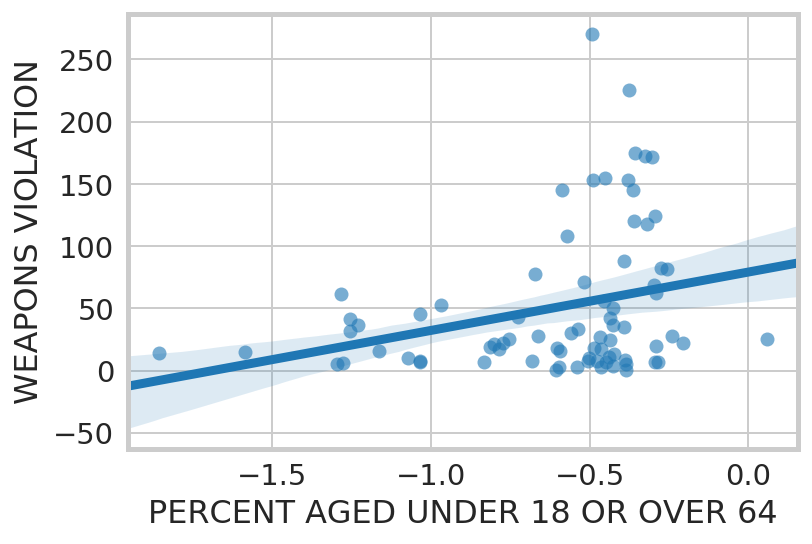

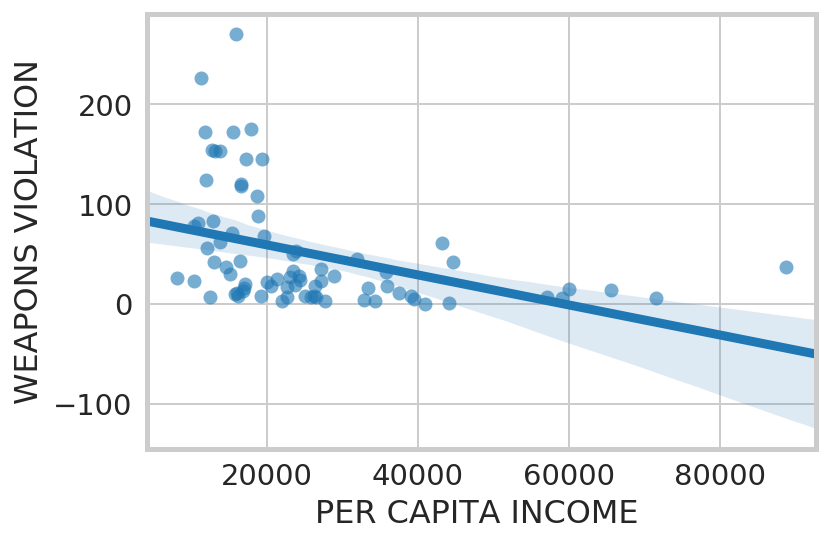

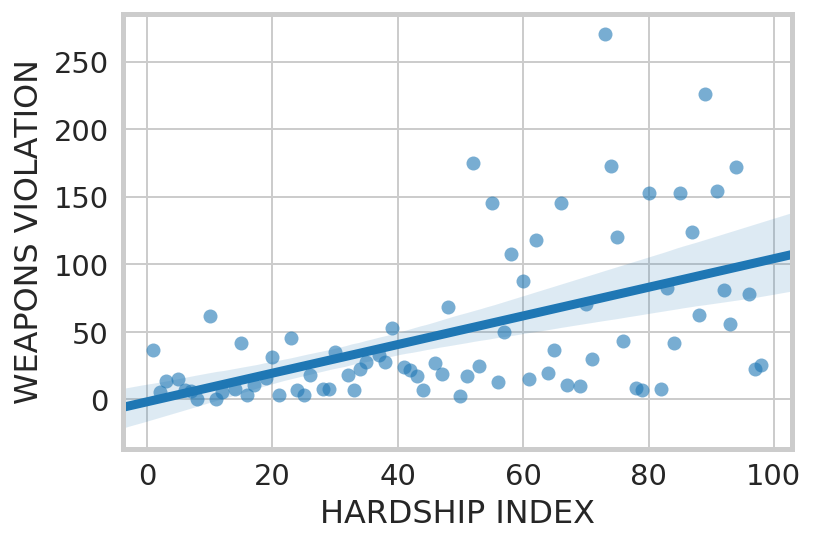

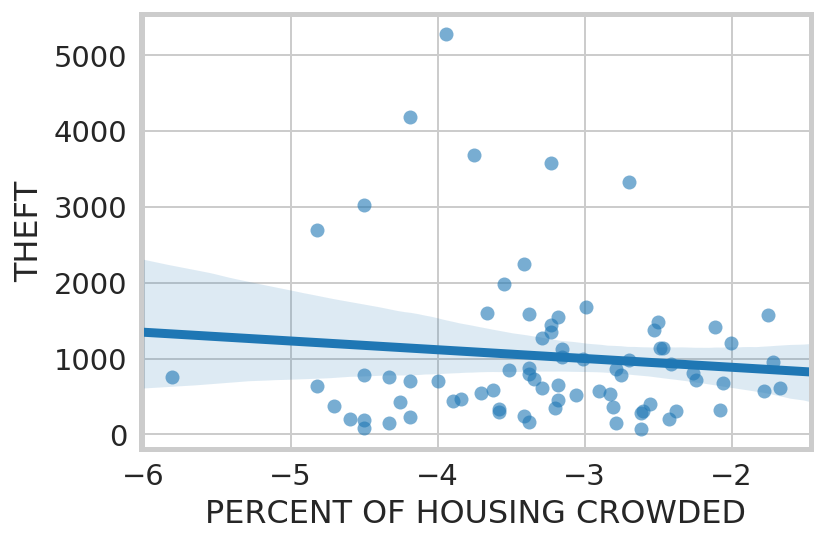

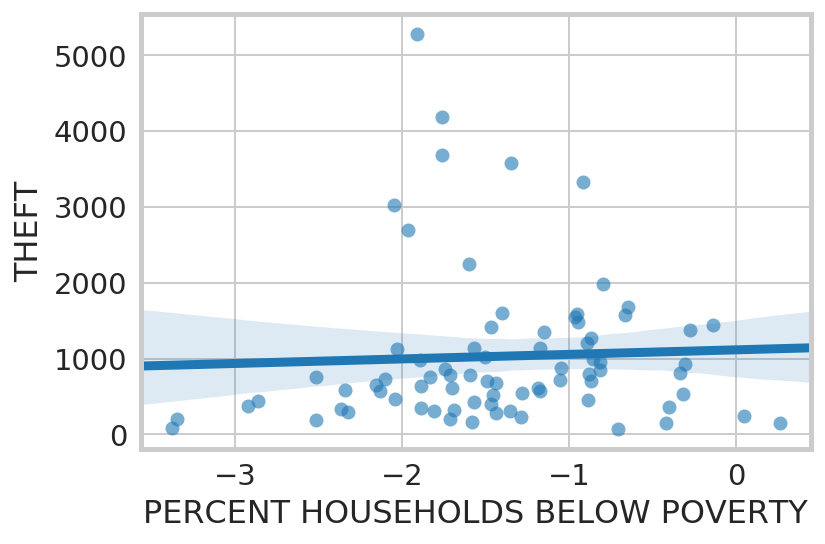

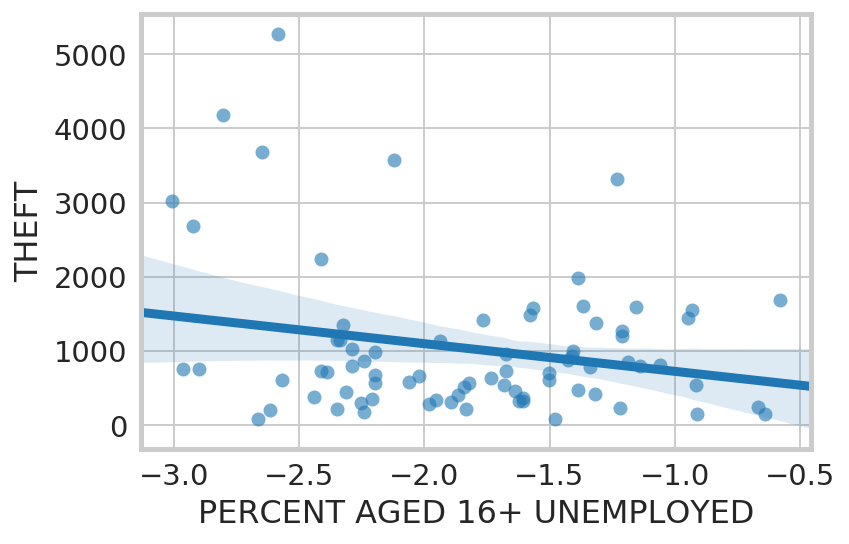

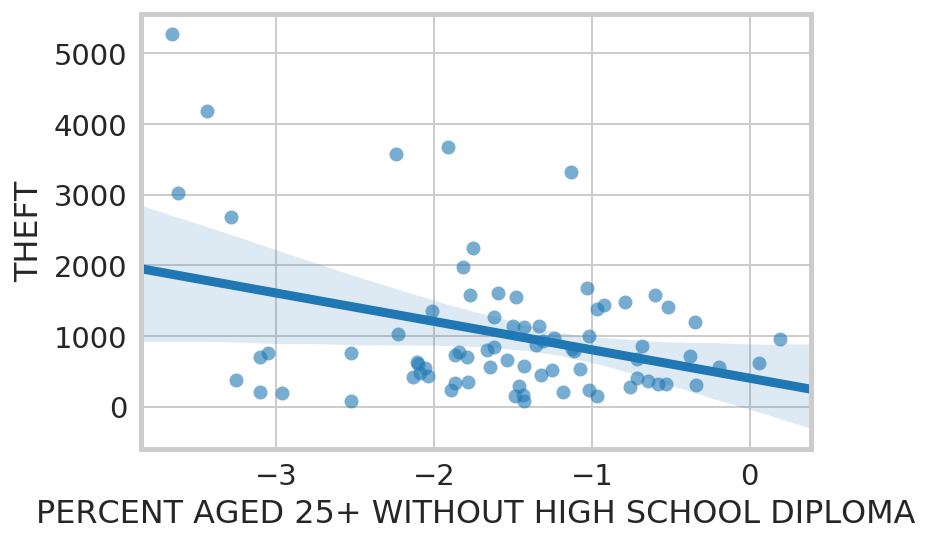

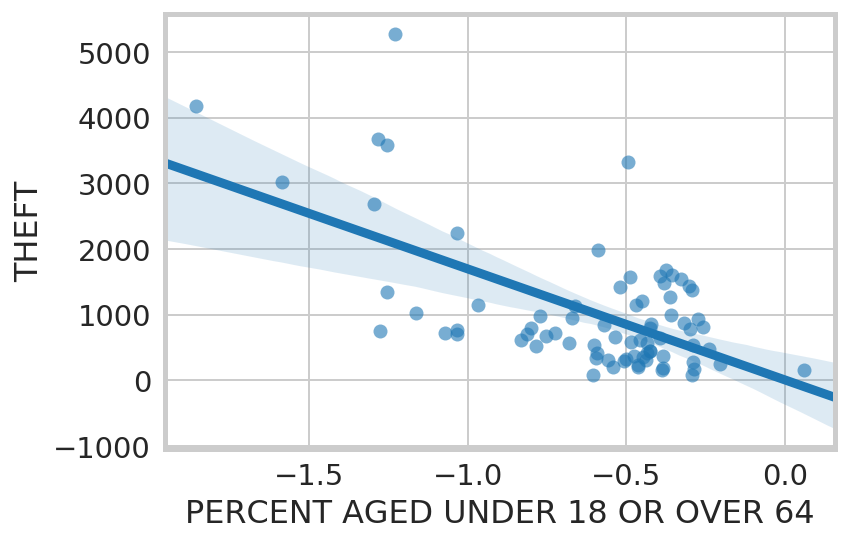

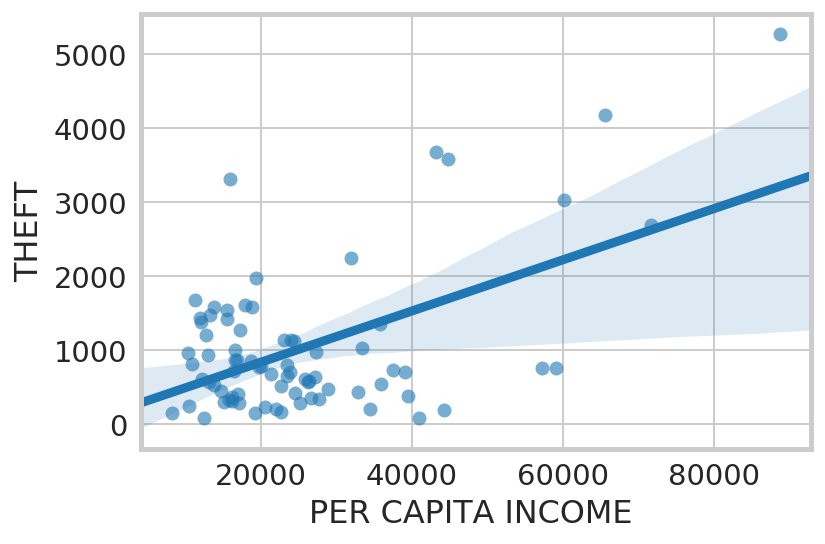

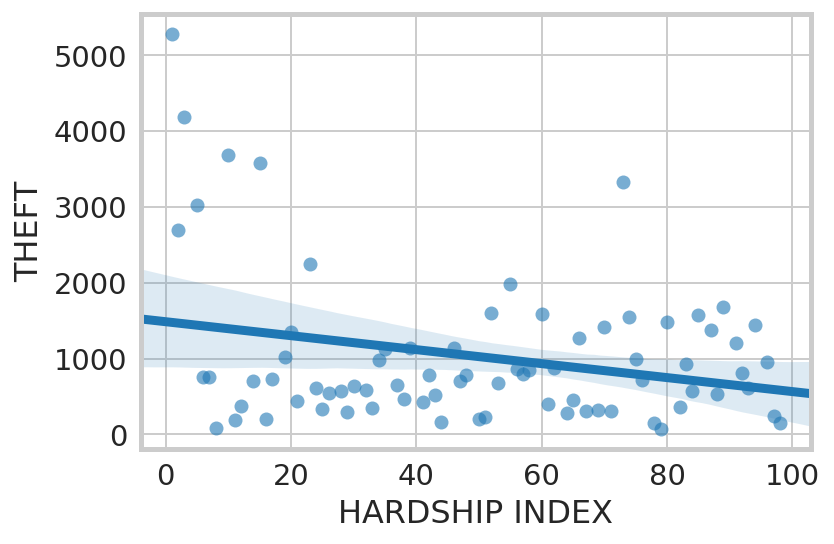

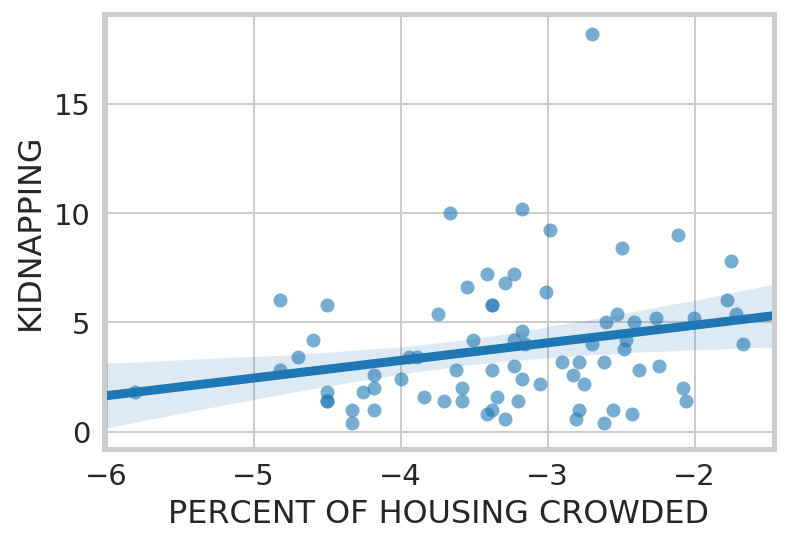

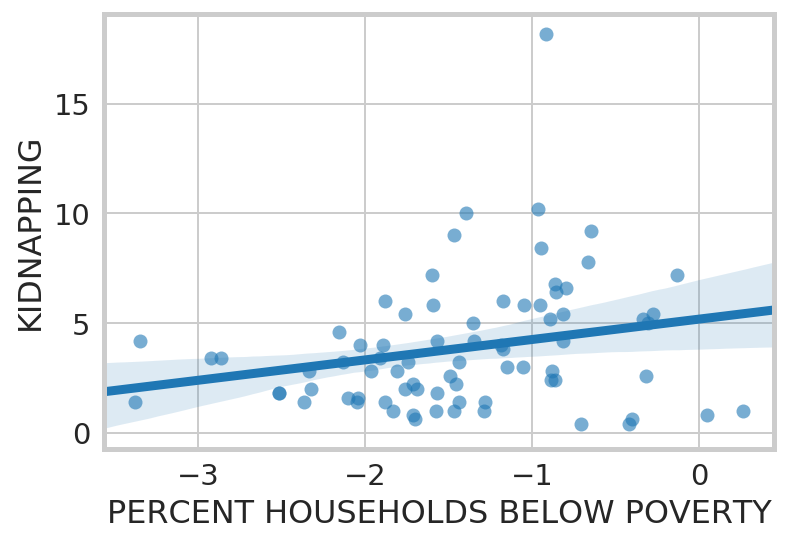

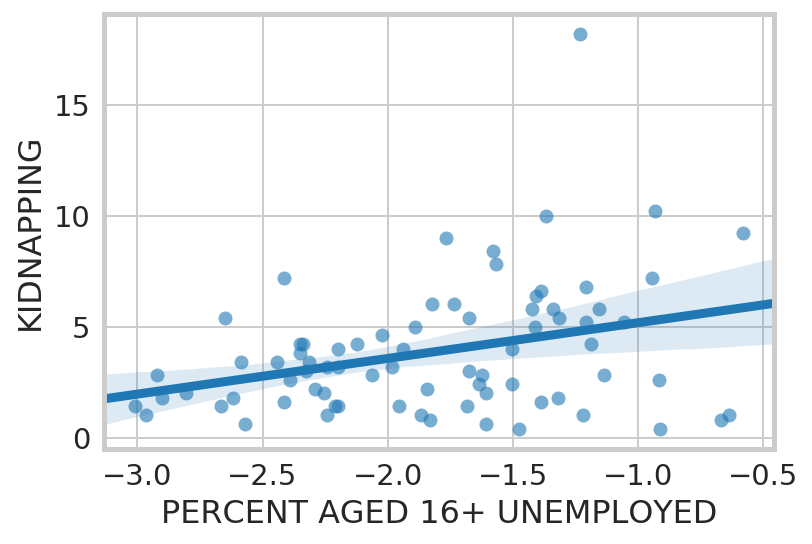

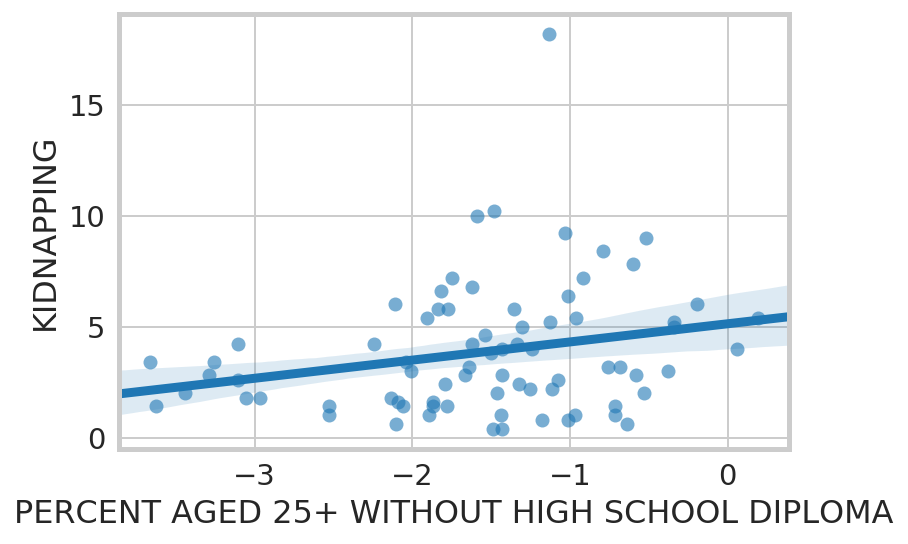

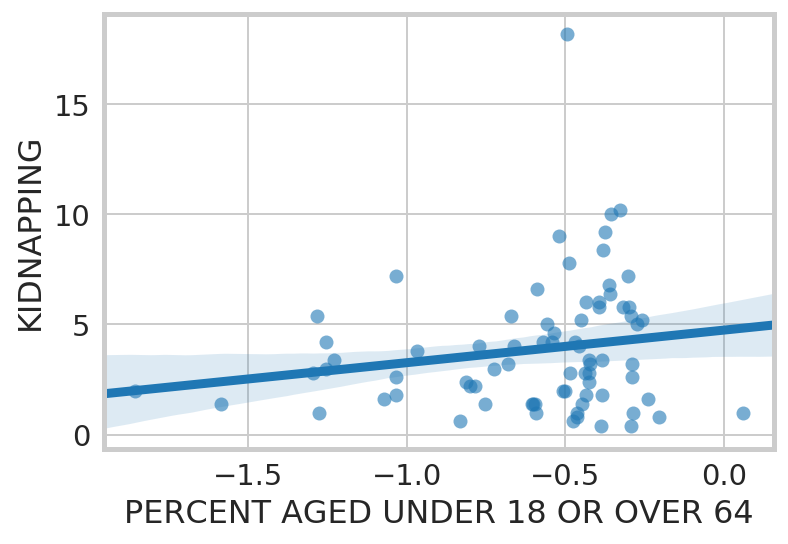

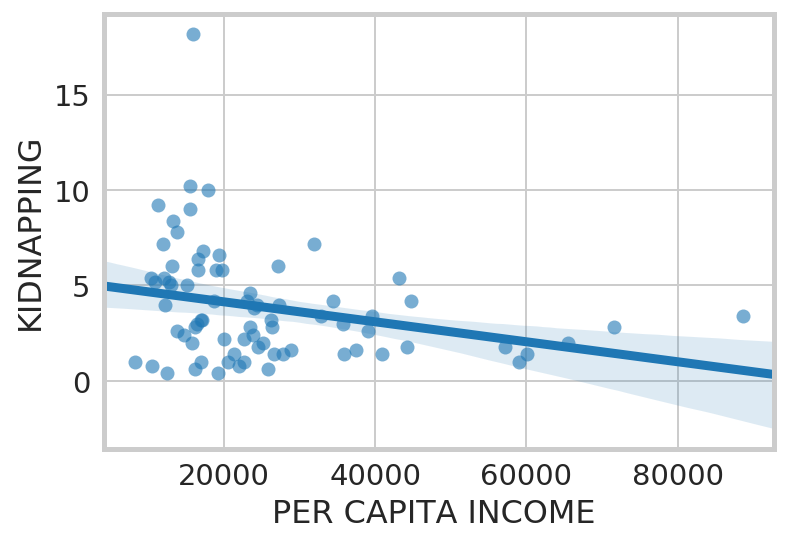

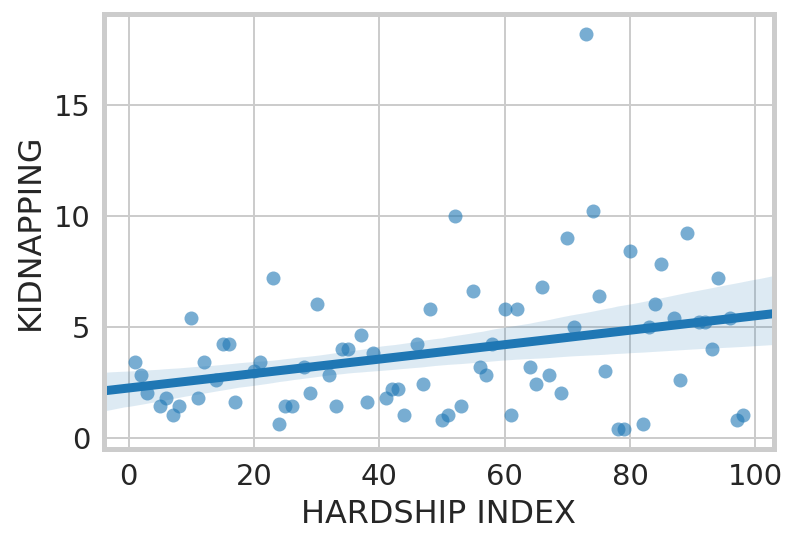

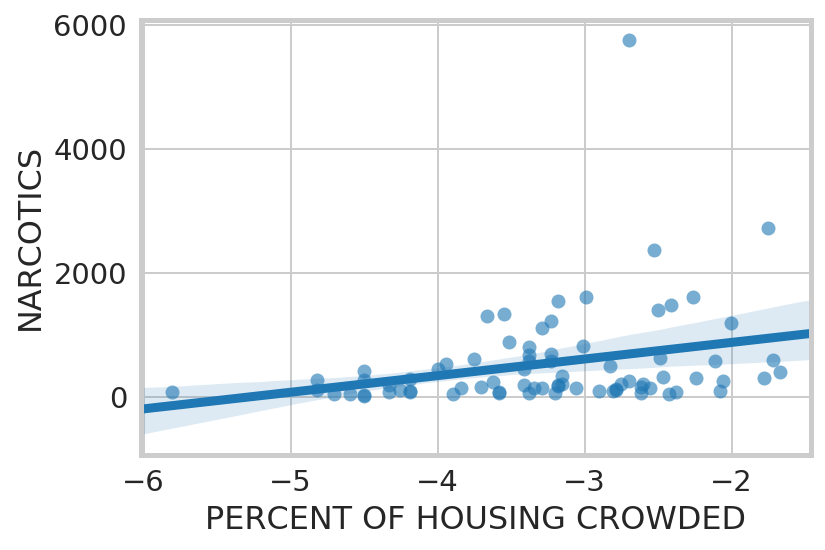

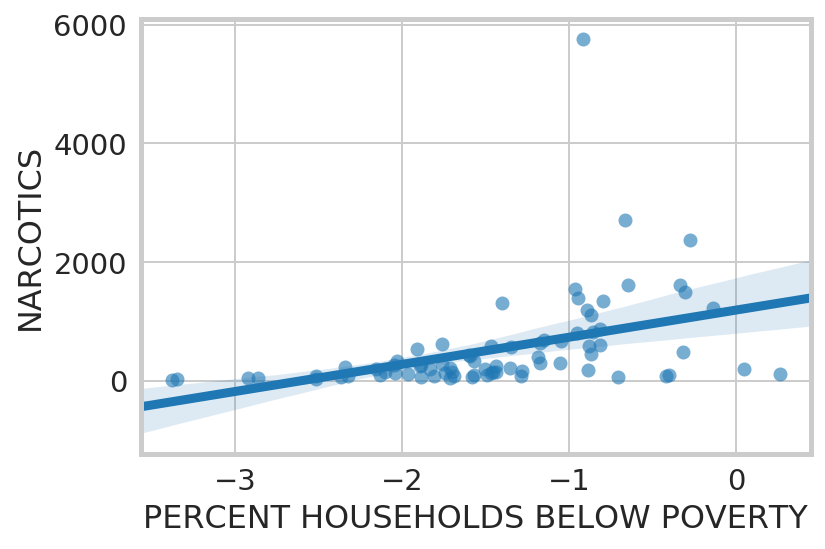

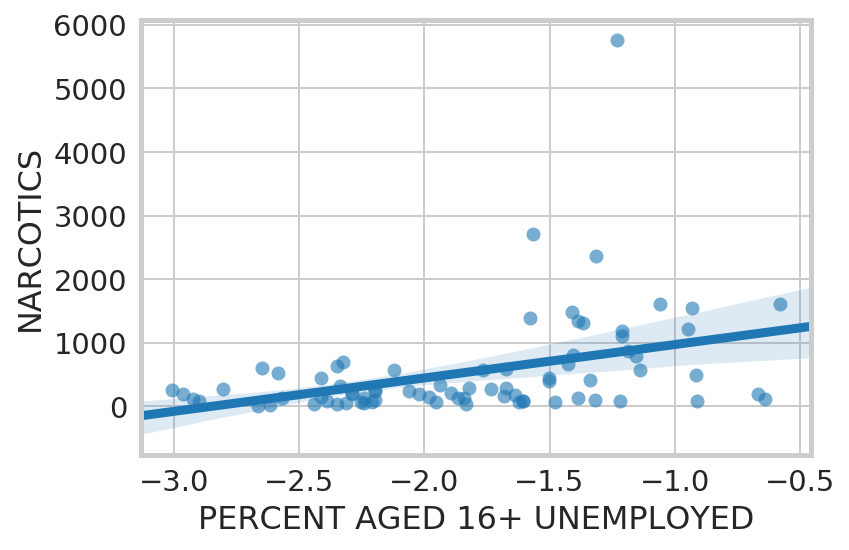

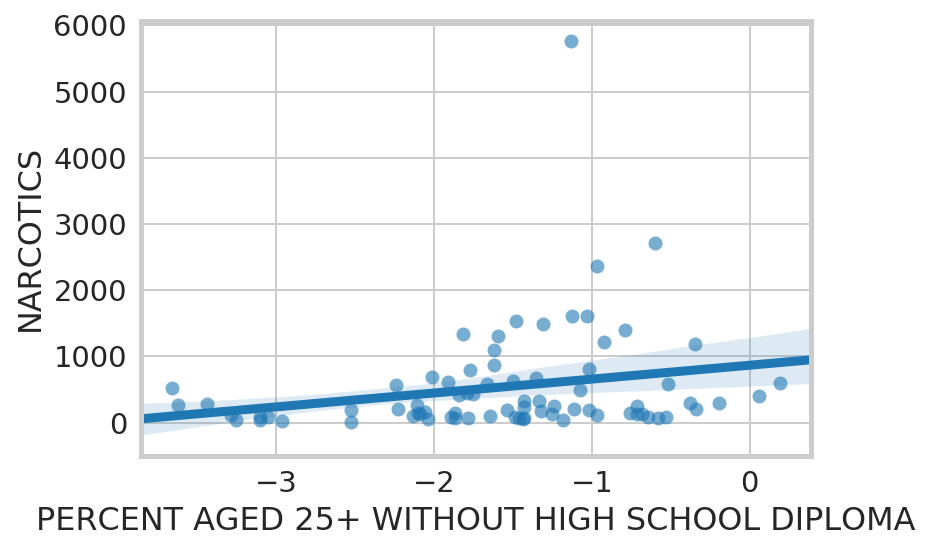

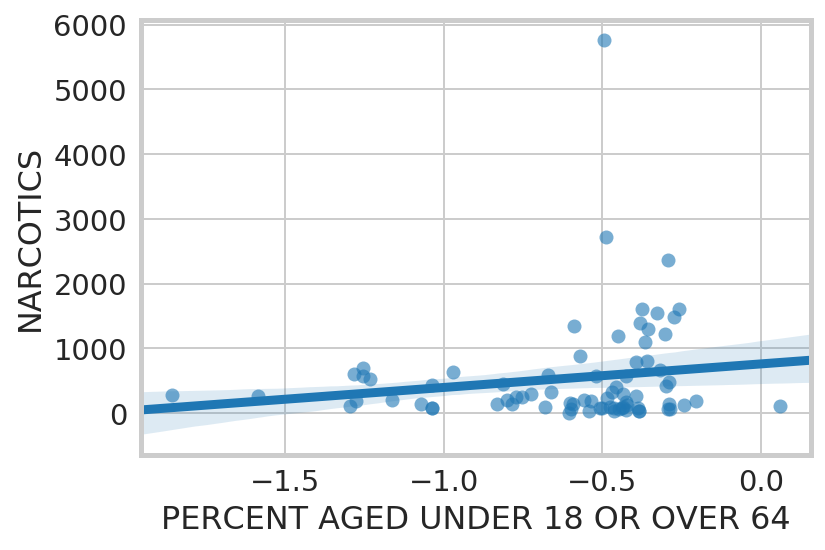

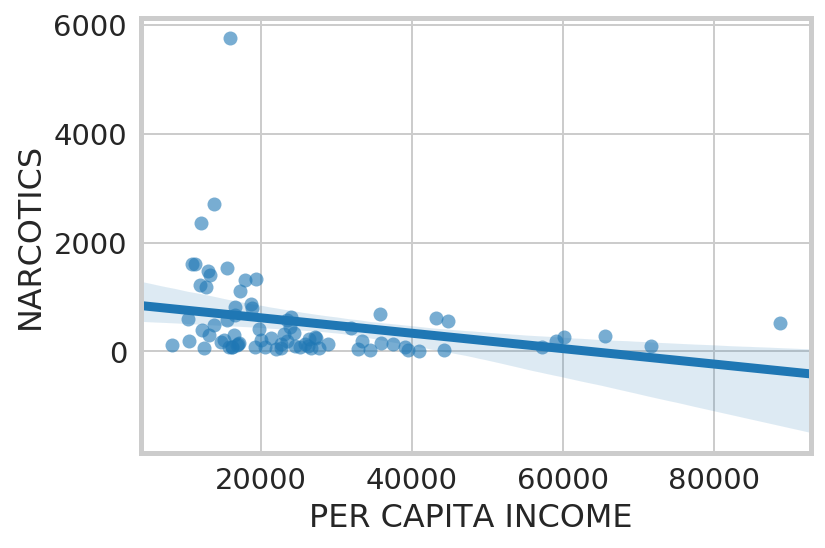

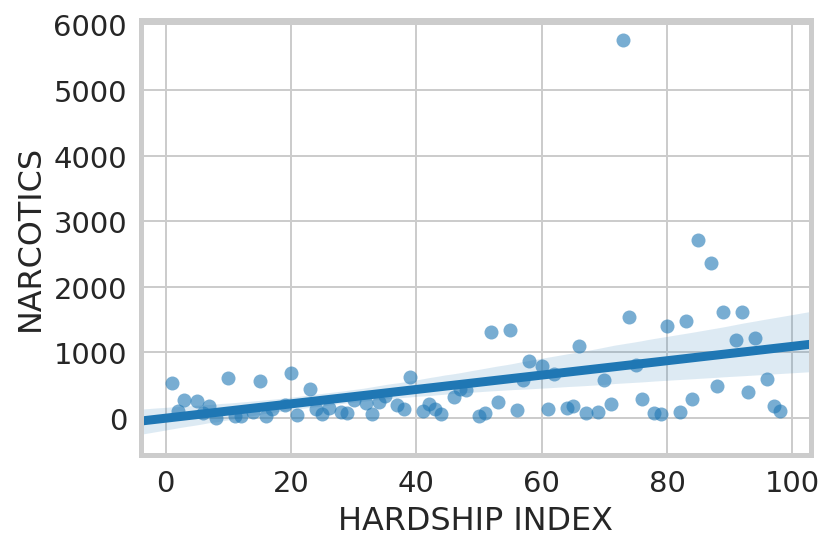

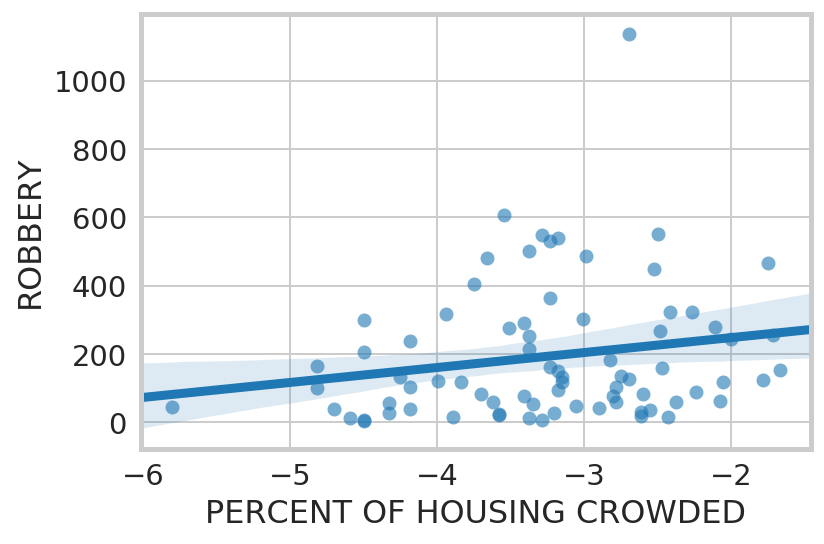

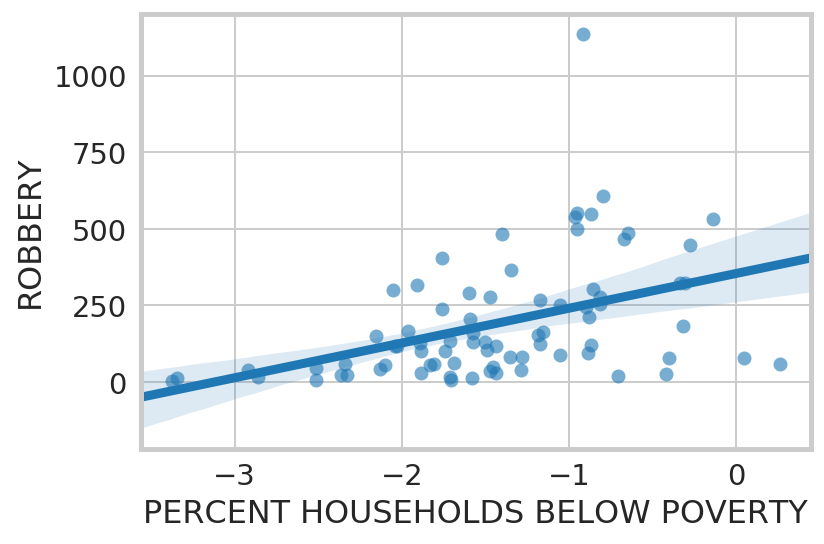

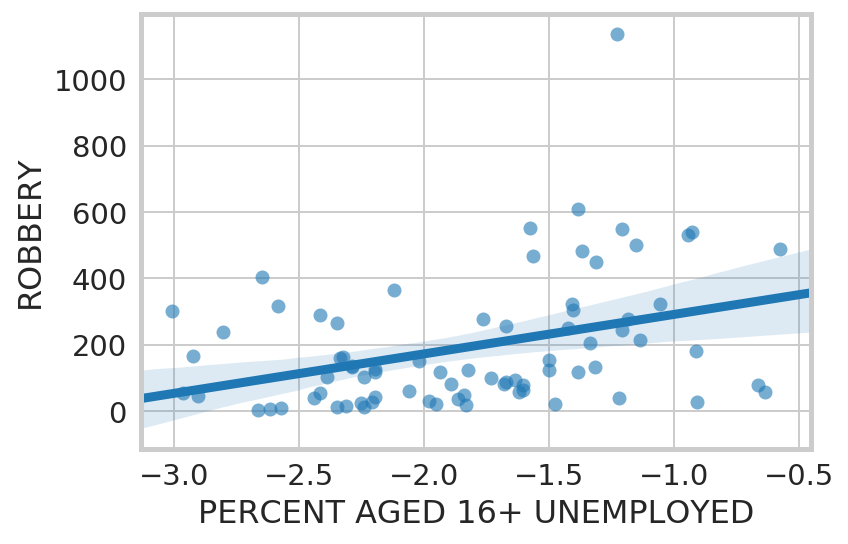

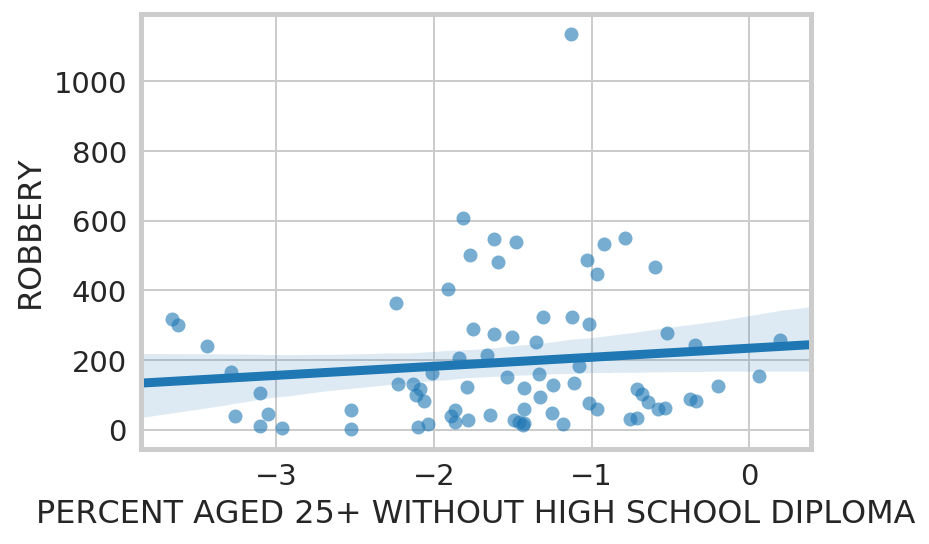

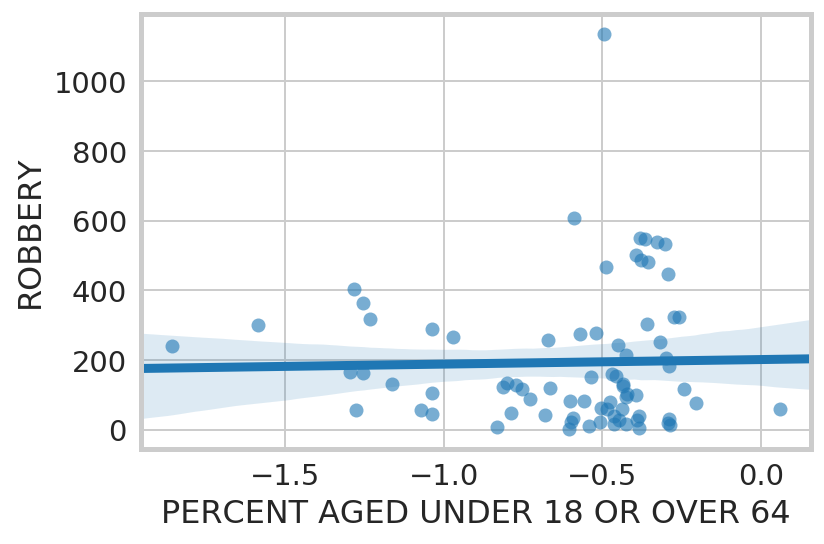

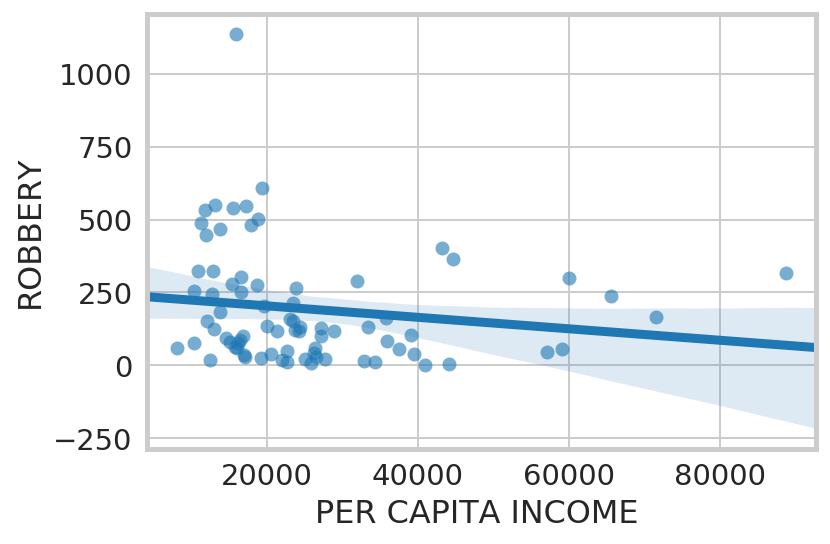

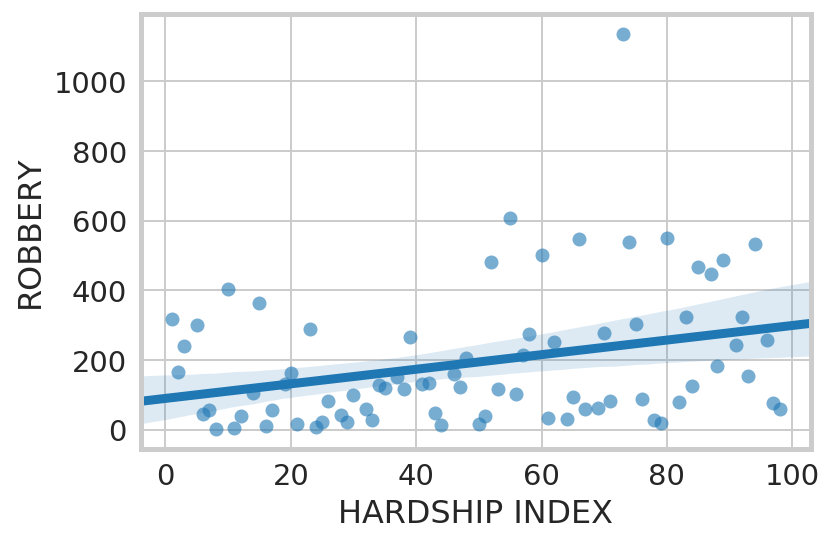

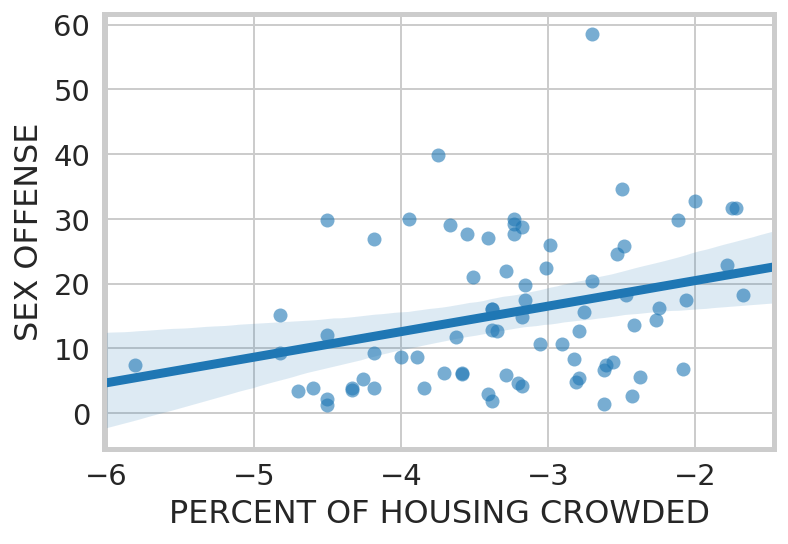

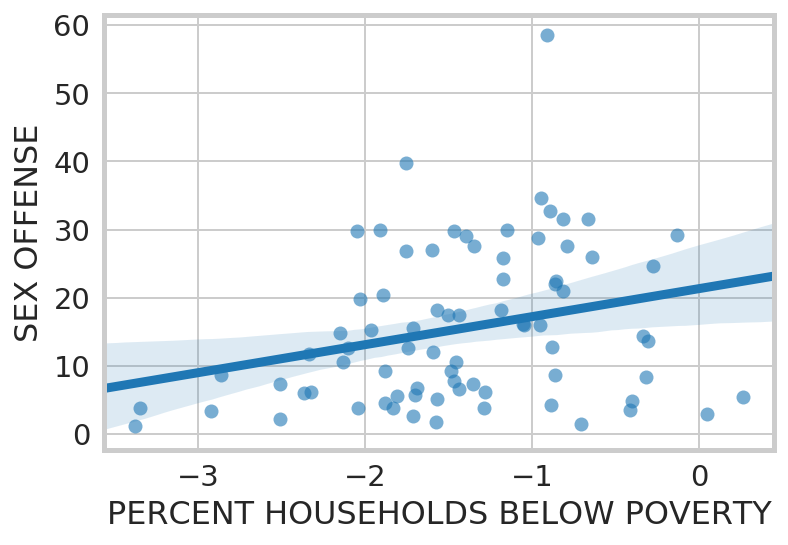

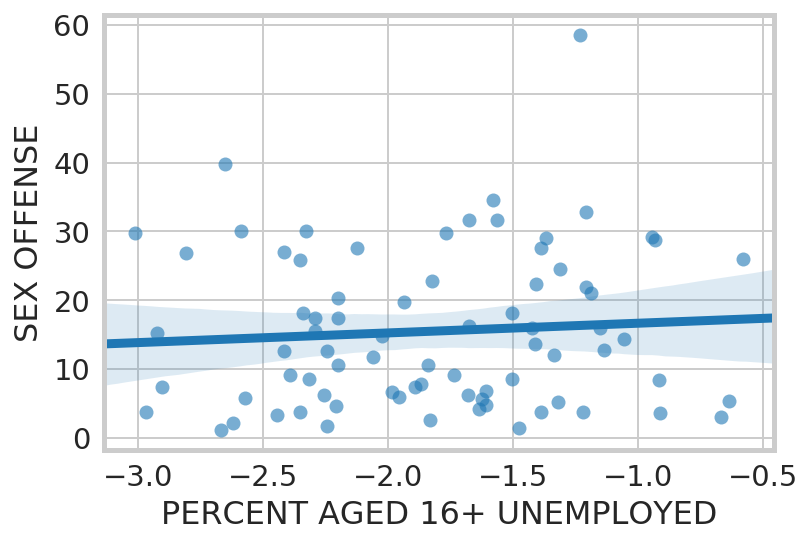

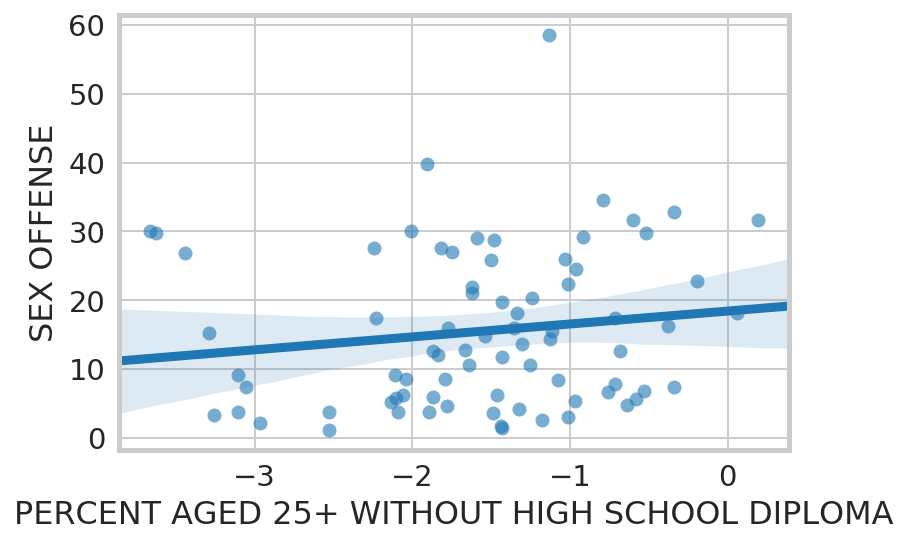

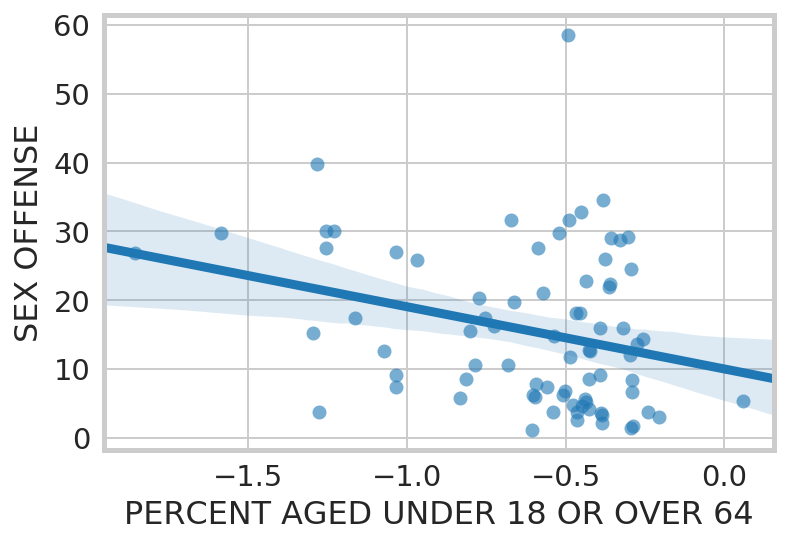

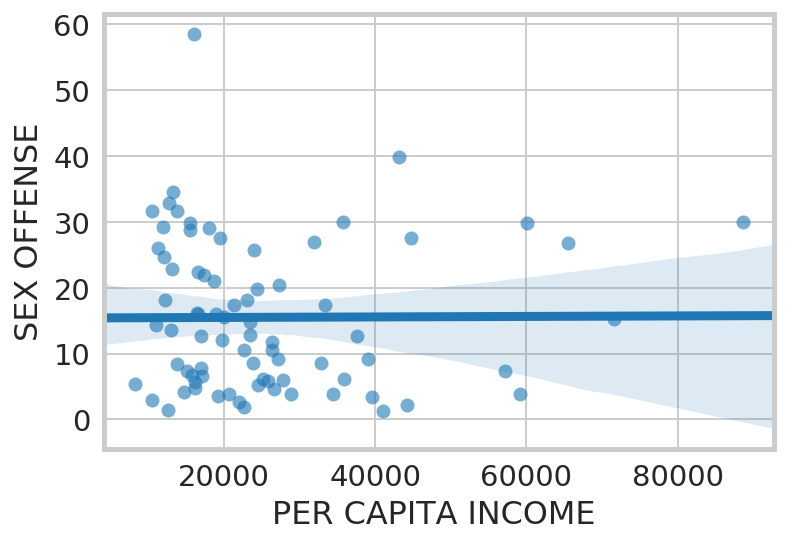

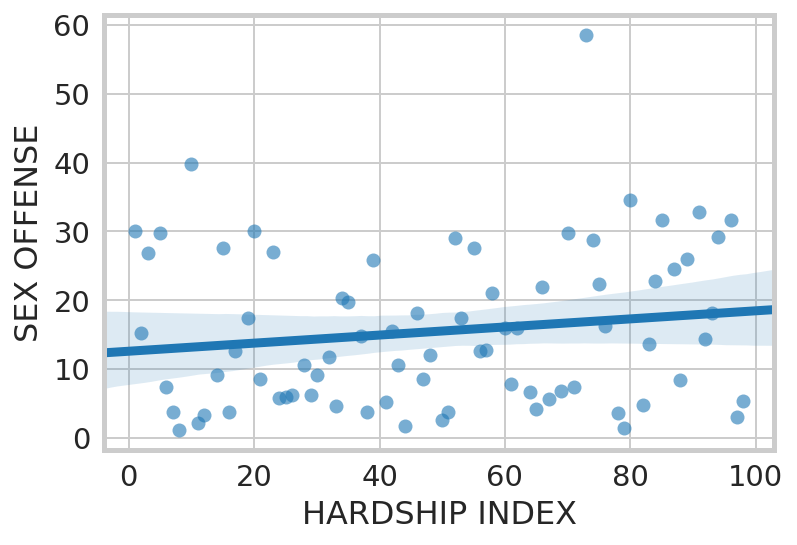

In [10]:
crimes_counter = 0
for crime in crimes_list:
    socio_counter = 0
    for socio in socio_list:
        crimes_df = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[crimes_counter])]
        ax = plt.figure()
        ax = sns.regplot(x = socio_list[socio_counter], y = 'No_Crimes', data = crimes_df, scatter_kws = {"alpha" : 0.6})
        ax.set_ylabel(crimes_list[crimes_counter])
#         ax.figure.savefig('output/primary_type/{}_{}.png'.format(socio_list[socio_counter], crimes_list[crimes_counter]), bbox_inches='tight', pad_inches=0.2)
        socio_counter += 1
    
    crimes_counter += 1

In [28]:
# homicide = mix_type_logit.loc[(mix_type['Primary_Type'] =='HOMICIDE')]  
# homicide_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = homicide, scatter_kws = {"alpha" : 0.6});
# homicide_hardship_plot.set_ylabel('Homicide')
# homicide_hardship_plot.figure.savefig("output/homicide_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [27]:
# weapons = mix_type_logit.loc[(mix_type_logit['Primary_Type'] =='WEAPONS VIOLATION')]  
# ax = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = weapons, scatter_kws = {"alpha" : 0.6});
# ax.set_ylabel('Weapons Violation')
# # weapons_hardship_plot.figure.savefig("output/weapons_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [26]:
# theft = mix_type_logit.loc[(mix_type['Primary_Type'] == 'THEFT')] 
# theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
# theft_hardship_plot.set_ylabel('Theft')
# theft_hardship_plot.figure.savefig("output/theft_hardship.png",  bbox_inches='tight', pad_inches=0.2)

In [19]:
# theft = mix_type.loc[(mix_type['Primary_Type'] == 'THEFT') | (mix_type['Primary_Type'] == 'MOTOR VEHICLE THEFT')] 
# theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
# theft_hardship_plot.set_ylabel('Theft')
# # theft_hardship_plot.figure.savefig("theft_hardship.png")

In [20]:
# narcotics = mix_type_logit.loc[(mix_type['Primary_Type'] == 'NARCOTICS')]  
# narcotics_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = narcotics, scatter_kws = {"alpha" : 0.6});
# narcotics_hardship_plot.set_ylabel('Narcotics')
# narcotics_hardship_plot.figure.savefig("output/narcotics_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [21]:
# kidnap = mix_type_logit.loc[(mix_type['Primary_Type'] == 'KIDNAPPING')]  
# kidnap_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = kidnap, scatter_kws = {"alpha" : 0.6});
# kidnap_hardship_plot.set_ylabel('Kidnap')
# kidnap_hardship_plot.figure.savefig("output/kidnap_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [22]:
# robbery = mix_type_logit.loc[(mix_type['Primary_Type'] == 'ROBBERY')]  
# robbery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = robbery, scatter_kws = {"alpha" : 0.6});
# robbery_hardship_plot.set_ylabel('Robbery')
# robbery_hardship_plot.figure.savefig("output/robbery_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [23]:
# battery = mix_type_logit.loc[(mix_type['Primary_Type'] == 'BATTERY')]  
# battery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = battery, scatter_kws = {"alpha" : 0.6}); 
# battery_hardship_plot.set_ylabel('Battery')
# battery_hardship_plot.figure.savefig("output/battery_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [35]:
def crime_df(v):
    x = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[v])]
    return x

In [40]:
crime_df(0)

,Community Area Number,No_Crimes,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
9,1.0,4.0,HOMICIDE,Rogers Park,-2.483824,-1.174736,-2.350828,-1.502856,-0.969401,23939,39.0
36,10.0,0.4,HOMICIDE,Norwood Park,-3.891820,-2.863259,-2.313635,-2.040656,-0.426343,32875,21.0
61,11.0,0.6,HOMICIDE,Jefferson Park,-3.584547,-2.363483,-1.955085,-1.866045,-0.597133,27751,25.0
87,12.0,0.4,HOMICIDE,Forest Glen,-4.498799,-2.512306,-2.617825,-2.965694,-0.384674,44164,11.0
111,13.0,0.8,HOMICIDE,North Park,-3.204413,-1.883390,-2.208385,-1.782457,-0.447312,26576,33.0
138,14.0,3.8,HOMICIDE,Albany Park,-2.060457,-1.437067,-2.197225,-0.712711,-0.753772,21323,53.0
165,15.0,1.8,HOMICIDE,Portage Park,-3.152319,-2.030867,-1.936798,-1.430633,-0.663294,24336,35.0
192,16.0,2.2,HOMICIDE,Irving Park,-2.699549,-1.892146,-2.197225,-1.242506,-0.772216,27249,34.0
219,17.0,1.0,HOMICIDE,Dunning,-2.903111,-2.132267,-2.197225,-1.643422,-0.681171,26282,28.0
244,18.0,0.8,HOMICIDE,Montclaire,-2.428837,-1.711263,-1.832002,-1.180290,-0.464158,22014,50.0


In [42]:
for v in range(6):
    print(crimes_list[v])
    crime_type = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age + Income",
                  data = crime_df(v).rename(columns = {"No_Crimes"                                 : "Crime", 
                                                     "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                     "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                     "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                     "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                     "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                     "PER CAPITA INCOME "                         : "Income",}))
    entry = crime_type.fit()
    print(entry.summary())

HOMICIDE
                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     7.113
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           6.58e-06
Time:                        18:22:33   Log-Likelihood:                -235.70
No. Observations:                  75   AIC:                             485.4
Df Residuals:                      68   BIC:                             501.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.6777      4.606      5.575

In [24]:
ols_homicide = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age +Income",
              data = homicide.rename(columns = {"No_Crimes"                                 : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",}))
model_homicide = ols_homicide.fit()
model_homicide.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Crime   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     7.113
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           6.58e-06
Time:                        15:54:16   Log-Likelihood:                -235.70
No. Observations:                  75   AIC:                             485.4
Df Residuals:                      68   BIC:                             501.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.6777      4.606      5.575      0.000      16.486      34.869
Crowd          2.9963      1.685      1.778      0.080      -0.367       6.359
Poverty        1.0706      1.825      0.587      0.559      -2.570       4.712
Unemp          7.8629      2.757      2.852      0.006       2.362      13.364
Edu           -2.4730      2.265     -1.092      0.279      -6.992       2.046
Age           -3.8019      3.790     -1.003      0.319     -11.364       3.760
Income     -7.178e-06      0.000     -0.057      0.955      -0.000       0.000
==============================================================================
Omnibus:                       17.777   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.481
Skew:                           0.921   Prob(JB):                     1.08e-06
Kurtosis:                       5.324   Cond. No.                     2.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# we can see that unemp and crwod are significant at 0.1 level 
ols_homicide = smf.ols(formula = "Crime ~ Crowd + Unemp",
              data = homicide.rename(columns = {"No_Crimes"                                 : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",}))
model_homicide = ols_homicide.fit()
model_homicide.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Crime   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     17.56
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           6.17e-07
Time:                        16:02:18   Log-Likelihood:                -239.07
No. Observations:                  75   AIC:                             484.1
Df Residuals:                      72   BIC:                             491.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.4065      3.054      7.009      0.000      15.318      27.495
Crowd          1.2466      0.876      1.424      0.159      -0.499       2.992
Unemp          6.1584      1.236      4.981      0.000       3.694       8.623
==============================================================================
Omnibus:                       18.837   Durbin-Watson:                   1.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.969
Skew:                           1.005   Prob(JB):                     8.45e-07
Kurtosis:                       5.217   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

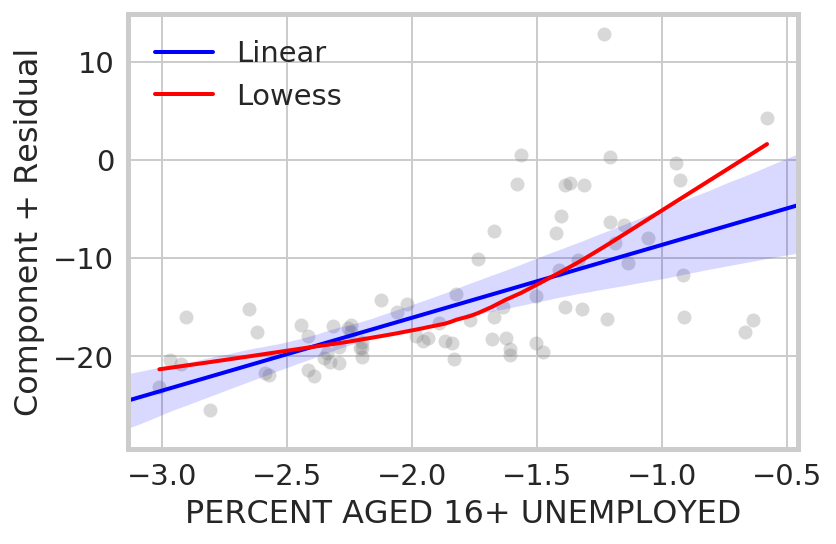

In [25]:
homicide_socio = pd.Series(name = "Component + Residual", data = model_homicide.resid + homicide["PERCENT AGED 16+ UNEMPLOYED"] * model_homicide.
                params["Unemp"])
ax = sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.3, "color" : "grey"})
sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = homicide["PERCENT AGED 16+ UNEMPLOYED"], y = homicide_socio, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend() 
ax.figure.savefig("output/homicide_unemp.png",  bbox_inches='tight', pad_inches=0.2)